In [1]:
from pathlib import Path
import datetime
import calendar
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import gridspec as gridspec
from pymongo import MongoClient
from scipy.interpolate import RBFInterpolator

# Load data
Step 0 is pulling events with the Sentry API

In [2]:
def load_event(event_name, unique=True):
    db = MongoClient().fmriprep_stats
    data = pd.DataFrame(list(db[event_name].find()))
    
    if len(data) == 0:
        raise RuntimeError(f"No records of event '{event_name}'")
    data.dateCreated = pd.to_datetime(data.dateCreated)
    data["date_minus_time"] = data["dateCreated"].apply(
        lambda df: datetime.datetime(year=df.year, month=df.month, day=df.day)
    )
    if unique is True:
        return data.drop_duplicates(subset=['run_uuid'])
    return data

## Processing "started" event

In [3]:
unique_started = load_event("started")
grouped_started = unique_started.groupby([
    unique_started['date_minus_time'].dt.isocalendar().year,
    unique_started['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_started

year  week
2022  36       1181
      37       7276
      38       5302
      39       8507
      40       5774
      41       7273
      42       6472
      43       6744
      44       7336
      45       7588
      46      10381
      47       7658
      48       8155
      49       8925
      50       7722
      51       8864
      52       5191
2023  1        4121
      2        7972
      3        8513
      4       16016
      5       16226
      6        9072
      7       10386
      8       11161
      9        8333
      10      14707
      11       8517
      12      12679
      13      13038
      14      10584
      15      13700
      16      11535
      17      10974
      18       9827
      19       7646
      20       8344
      21       7494
      22       8343
      23       9141
      24      10223
      25      10108
      26      11336
      27       8987
      28      13256
      29      11540
      30      10546
      31      11318
      32       9663
Name: id,

## Processing "success" event

In [4]:
unique_success = load_event("success")
grouped_success = unique_success.groupby([
    unique_success['date_minus_time'].dt.isocalendar().year,
    unique_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_success

year  week
2022  36        672
      37       4709
      38       4004
      39       5765
      40       4237
      41       4909
      42       4442
      43       4352
      44       4904
      45       5026
      46       8420
      47       5877
      48       6184
      49       6591
      50       4902
      51       6715
      52       3824
2023  1        2956
      2        4840
      3        6085
      4       14232
      5       13276
      6        6637
      7        7495
      8        8062
      9        5829
      10      11685
      11       6055
      12       9936
      13       9820
      14       7492
      15      10804
      16       8699
      17       8132
      18       7633
      19       5554
      20       5738
      21       5492
      22       5466
      23       6305
      24       7971
      25       7309
      26       7485
      27       6862
      28       9796
      29       9431
      30       8109
      31       8404
      32       7755
Name: id,

In [5]:
unique_started_success = unique_success.loc[unique_success['run_uuid'].isin(unique_started['run_uuid'])]
grouped_started_success = unique_started_success.groupby([
    unique_started_success['date_minus_time'].dt.isocalendar().year,
    unique_started_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()

In [6]:
indexes = grouped_started.index[1:-1]
year_index = indexes.droplevel("week")
years = sorted(year_index.unique())
weeks_per_year = [(year_index == yr).sum() for yr in years]

## Massage versions

In [7]:
unique_started.environment_version.fillna("older", inplace=True)
unique_started_success.environment_version.fillna("older", inplace=True)

unique_started.environment_version[unique_started.environment_version == "v0.0.1"] = "older"
unique_started_success.environment_version[unique_started.environment_version == "v0.0.1"] = "older"

unique_started.environment_version[unique_started.environment_version.str.startswith("20.0")] = "older"
unique_started_success.environment_version[unique_started.environment_version.str.startswith("20.0")] = "older"

unique_started.environment_version[unique_started.environment_version.str.startswith("20.1")] = "older"
unique_started_success.environment_version[unique_started.environment_version.str.startswith("20.1")] = "older"

versions = sorted(unique_started["environment_version"].unique())
versions = sorted(set([v[:4] for v in versions if v != "older"]))
# versions.insert(0, "older")

/tmp/ipykernel_142967/1887377358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_started_success.environment_version.fillna("older", inplace=True)
/tmp/ipykernel_142967/1887377358.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_started.environment_version[unique_started.environment_version == "v0.0.1"] = "older"
/tmp/ipykernel_142967/1887377358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_started_suc

In [8]:
unique_started.environment_version

0         22.0.2
1         22.0.2
2         22.0.2
3         22.0.2
4         22.0.2
           ...  
455650    20.2.6
455651    20.2.6
455652    21.0.0
455653    20.2.3
455654    20.2.6
Name: environment_version, Length: 455655, dtype: object

## Successful runs per week

In [9]:
# Extract some summary stats
success_data = grouped_success[1:-1]
started_data = grouped_started[1:-1]

abs_success_mean = success_data.values.mean()

success_ratio = 100 * success_data / started_data
success_mean = success_ratio.values.mean()

max_success = (np.argmax(success_ratio), success_ratio.values.max())
max_date = indexes[max_success[0]]
min_success = (np.argmin(success_ratio), success_ratio.values.min())
min_date = indexes[min_success[0]]

<Figure size 432x288 with 0 Axes>

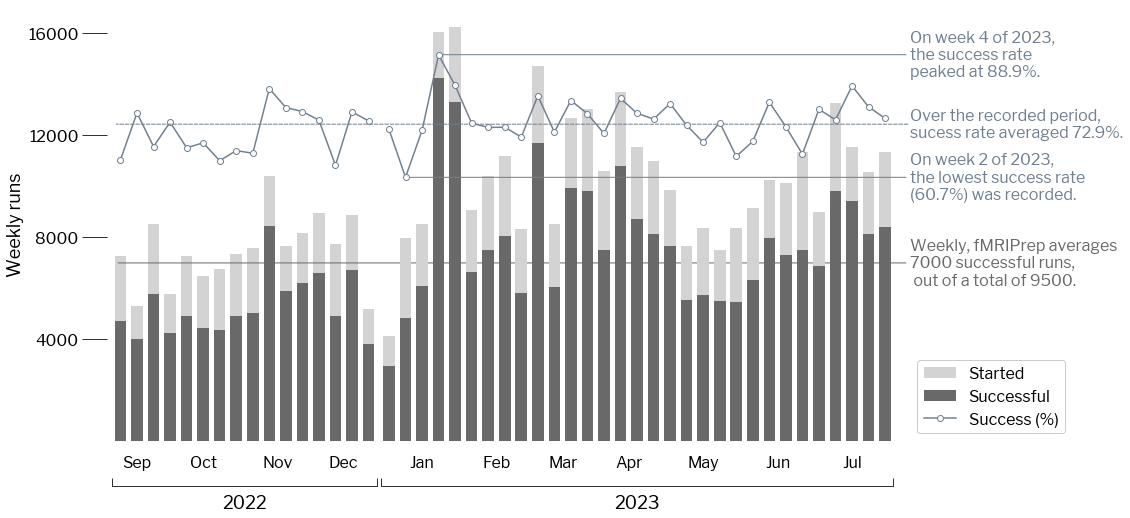

In [10]:
plt.clf()

plt.rcParams["font.family"] = "Libre Franklin"

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey=True,
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(14,8),
)

xlength = []
yticks = [4000, 8000, 12000, 16000]
year_start_index = 0
for ax_i, yr in enumerate(years):
    x = np.arange(len(started_data[year_index == yr]), dtype=float) + 0.5
    
    bar1 = axes[ax_i].bar(
        x,
        started_data[year_index == yr].values,
        width=0.7,
        label='Started',
        color="lightgrey",
        zorder=4,
    )
    bar2 = axes[ax_i].bar(
        x,
        success_data[year_index == yr].values,
        width=0.7,
        label='Successful',
        color="dimgrey",
        zorder=4,
    )

    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    axes[ax_i].spines['bottom'].set_position(('outward', 45))
    
    xlength.append(len(x))
    axes[ax_i].set_xlim((0.0, xlength[-1]))
    axes[ax_i].set_xticks((0.0, xlength[-1]))
    axes[ax_i].set_xticklabels([])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)

    axes[ax_i].yaxis.set_tick_params(length=0)

    if ax_i > 0:
        axes[ax_i].set_yticks([])
        
    ax2 = axes[ax_i].twinx()
    lineplot = ax2.plot(
        x,
        success_ratio[year_index == yr].values,
        'o-',
        label="Success (%)",
        color="slategray",
        mfc="white",
        zorder=4,
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks([])

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    # Label months
    months = [
        datetime.datetime.strptime(f'{yr}-W{week}-1', "%Y-W%W-%w").month
        for _, week in indexes[year_index == yr]
    ]
    for mname in sorted(set(months)):
        month_x = 0.5 * (xlength[-1] - months[::-1].index(mname) + months.index(mname))
        axes[ax_i].text(
            month_x,
            -1000,
            f"{calendar.month_abbr[mname]}",
            fontsize=16,
            ha="center",
#             transform="data",
        )

# Configure y-axis arts
axes[0].set_yticks(yticks, labels=yticks)
axes[0].yaxis.set_tick_params(length=25, labelsize=16)
axes[0].spines['left'].set_position(('outward', 30))
axes[0].spines['left'].set_color("dimgray")
axes[0].set_ylabel("Weekly runs", fontsize=18);


# Add annotations
axes[-1].annotate(
    "Weekly, fMRIPrep averages\n"
    f"{int(round(abs_success_mean, -2))} successful runs,"
    "\n"
    f" out of a total of {int(round(grouped_started.values[1:-1].mean(), -2))}.",
    xy=(0 - sum(xlength[:-1]), abs_success_mean),
    xytext=(xlength[-1] + 1, abs_success_mean),
    xycoords="data",
    annotation_clip=False,
    color="dimgrey",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "dimgrey"},
).set_zorder(-5)

ax2.annotate(
    "Over the recorded period,\n"
    f"sucess rate averaged {round(success_mean, 1)}%.",
    xy=(0 - sum(xlength[:-1]), success_mean),
    xytext=(xlength[-1] + 1, success_mean),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "slategray",  "linestyle" : "--", "shrinkA": 0, "shrinkB": 0},
).set_zorder(-0.5)

ax2.annotate(
    f"On week {max_date[1]} of {max_date[0]},"
    "\nthe success rate\npeaked at "
    f"{round(max_success[1], 1)}%.",
    xy=(max_date[1] - 0.5, round(max_success[1], 1)),
    xytext=(xlength[-1] + 1, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)

ax2.annotate(
    f"On week {min_date[1]} of {min_date[0]},"
    "\nthe lowest success rate \n"
    f"({round(min_success[1], 1)}%) was recorded.",
    xy=(min_date[1] - 0.5, round(min_success[1], 1)),
    xytext=(xlength[-1] + 1, round(min_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)


#plt.ylabel("Success rate (%)")

patches = [bar1, bar2, lineplot[0]]
axes[-1].legend(
    patches,
    [p.get_label() for p in patches],
    loc='lower right',
    bbox_to_anchor=(1.35, 0.),
    framealpha=1,
    mode=None,
    prop={"size": 16}
);
plt.savefig(
    f"{datetime.date.today().strftime('%Y%m%d')}_weekly.png",
    dpi=300,
    bbox_inches='tight',
    facecolor="w",
    edgecolor="w",
)

# Analysis by version

In [11]:
versions_success = {}
versions_started = {}

for version in versions:
    ver_suc = unique_started_success[unique_started_success.environment_version.str.startswith(version)]
    ver_sta = unique_started[unique_started.environment_version.str.startswith(version)]
    
    versions_success[version] = ver_suc.groupby([
        ver_suc['date_minus_time'].dt.isocalendar().year,
        ver_suc['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()
    versions_started[version] = ver_sta.groupby([
        ver_sta['date_minus_time'].dt.isocalendar().year,
        ver_sta['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()

versions_success = pd.DataFrame(versions_success)
versions_started = pd.DataFrame(versions_started)
versions_success_norm = versions_success.div(versions_success.sum(axis=1), axis=0)

In [12]:
data = versions_success[1:-1].fillna(0.0)
xs = np.arange(len(data))
xnew = np.linspace(0.0, len(data), num=14 * len(data))
xnew_inc = xnew[1] - xnew[0]

smoothed_data = RBFInterpolator(xs[:, np.newaxis], data.values)(xnew[:, np.newaxis])

In [13]:
xlims

NameError: name 'xlims' is not defined

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey="row",
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(16,6),
)

labels = versions_success.columns
colors = [plt.cm.YlGnBu_r(i / (len(labels))) for i, _ in enumerate(labels)]

xlims = []
year_start_index = 0
for ax_i, yr in enumerate(years):
    if ax_i > 0:
        axes[ax_i].set_yticklabels([])
        axes[ax_i].set_yticks([])

    xaxis = np.arange(len(data[year_index == yr]))
    axes[ax_i].stackplot(
        xnew,
        smoothed_data.T,
        baseline="sym",
        labels=labels,
        colors=colors,
    )
     
    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    # axes[ax_i].spines['bottom'].set_visible(False)
    
    year_end_index = year_start_index + weeks_per_year[ax_i]
    xlims.append((year_start_index, year_end_index))
    
    axes[ax_i].set_xlim(xlims[-1])
    axes[ax_i].set_xticklabels([])
    axes[ax_i].set_xticks(xlims[-1])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)
    year_start_index = year_end_index


axes[0].annotate(
    "20.2 (LTS)",
    xy=(0, -1000),
    xytext=(-1, -1000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=16,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "square",
        "fc": colors[0],
        "color": "w",
        "pad": 0.5,
    },
)

axes[0].annotate(
    labels[1],
    xy=(0, 0),
    xytext=(-1, 800),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "square",
        "fc": colors[1],
        "color": "w",
        "pad": 0.5,
    },
)

axes[0].annotate(
    labels[2],
    xy=(0, 0),
    xytext=(-1, 2200),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "square",
        "fc": colors[2],
        "color": "w",
        "pad": 0.5,
    },
)


axes[1].annotate(
    labels[3],
    xy=(xlims[0][1] - 2, 3000),
    xytext=(xlims[0][1] - 2, 5000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[3],
        "ec": colors[3],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[3],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[1].annotate(
    labels[4],
    xy=(xlims[1][0] + 10, 2800),
    xytext=(xlims[1][0] + 10, 6000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[4],
        "ec": colors[4],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[4],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[1].annotate(
    labels[5],
    xy=(xlims[1][0] + 23, 2800),
    xytext=(xlims[1][0] + 23, 6000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="darkgray",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[5],
        "ec": colors[5],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[5],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

# axes[0].annotate(
#     "Version 20.2 (LTS)\n"
#     "was last released\non Jan 24, 2022",
#     xy=(0, -1000),
#     xytext=(-2, -5000),
#     textcoords='data',
#     xycoords="data",
#     fontweight=500,
#     annotation_clip=False,
#     color="w",
#     size=16,
#     horizontalalignment="center",
#     verticalalignment="center",
#     arrowprops={
#         "arrowstyle": "-",
#         "connectionstyle": "angle",
#         "color": colors[0],
#     },
#     bbox={
#         "boxstyle": "square",
#         "fc": colors[0],
#         "color": "w",
#         "pad": 0.8
#     },
# )

# plt.tight_layout()

# plt.ylabel("Number of successful runs, broken by version")
# plt.xlabel("Week of year")
# plt.title("Version adoption")
# plt.legend(ncol=len(labels), loc='lower left');
plt.savefig('20221206_version_successful_weekly_abs.png', dpi=300, bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.T / versions_started.sum(axis=1)).T * 100).plot.bar(stacked=True, ax=ax)

ax.set_ylim((0,100))
plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_total.png', dpi=300, bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.sum(axis=0) / versions_started.sum(axis=0)) * 100).plot.bar(ax=ax, width=1.0)

ax.set_ylim((0,100))

plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Release version")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_broken.png', dpi=300, bbox_inches='tight')

In [ ]:
versions_success.sum(axis=0)

In [ ]:
versions_started.sum(axis=0)